In [1]:
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

from plotting import validation_titration_plot, COLOR_PURPLE

In [2]:
df = pd.read_excel('../data/internal/2019-08-28 Luciferase results.xlsx',
              sheet_name='Use for analyses')
df = df.iloc[:, 0:15]
df['Y1H_positive'] = df['Interaction?'].map({'yes': True, 'no': False})
if df.isnull().any().any():
    raise UserWarning('Unexpected missing values')
if df.duplicated(subset=['Bait', 'unique_acc']).any():
    raise UserWarning('unexpected duplicates')

In [3]:
df.head()

,Set,Interaction?,Bait,TF_Name,unique_acc,Plate-well,Replicate1,Replicate2,Replicate3,Average (empty-pEZY3-VP160),Foldchange1,Foldchange2,Foldchange3,Average,Log2(FC),Y1H_positive
0,eY1Hvalidation,no,HS281,DLX1,DLX1|2/2|07E09,18-C4,0.088103,0.097955,0.088123,0.186988,0.471169,0.523857,0.471278,0.488768,-1.032779,False
1,eY1Hvalidation,no,HS598,DLX1,DLX1|2/2|07E09,12-G5,0.143830,0.132734,0.132411,0.218959,0.656880,0.606203,0.604731,0.622604,-0.683612,False
2,eY1Hvalidation,no,HS1419,DLX4,DLX4|3/3|10B05,13-B10,0.067359,0.064723,0.067650,0.081857,0.822884,0.790680,0.826442,0.813335,-0.298078,False
3,eY1Hvalidation,no,HS281,DLX4,DLX4|3/3|10B05,18-C7,0.111438,0.122384,0.104692,0.186988,0.595966,0.654504,0.559885,0.603452,-0.728690,False
4,eY1Hvalidation,no,HS281,DLX4,DLX4|1/3|11A04,18-C5,5.834440,5.667983,5.528556,0.186988,31.202254,30.312047,29.566401,30.360234,4.924111,False


In [4]:
df['Set'].value_counts()

eY1Hvalidation    141
Name: Set, dtype: int64

In [5]:
# TODO summary stats
print('In PDI validation experiment, tested:')
print(df['TF_Name'].nunique(), 'different TF genes')
print(df['unique_acc'].nunique(), 'different TF isoforms')
print(df['Bait'].nunique(), 'different baits')
print(df.shape[0], 'total PDIs')

In PDI validation experiment, tested:
19 different TF genes
48 different TF isoforms
41 different baits
141 total PDIs


In [6]:
print('Isoforms per gene:')
df.groupby(['TF_Name'])['unique_acc'].nunique().value_counts().sort_index()

Isoforms per gene:


2     9
3    10
Name: unique_acc, dtype: int64

In [7]:
print('Baits per isoform:')
df.groupby(['unique_acc'])['Bait'].nunique().value_counts().sort_index()

Baits per isoform:


2    18
3    15
4    15
Name: Bait, dtype: int64

In [8]:
df['Interaction?'].value_counts()

yes    86
no     55
Name: Interaction?, dtype: int64

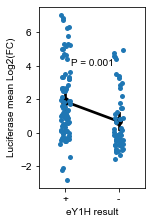

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=3.)
sns.stripplot(data=df, x='Interaction?', y='Log2(FC)', ax=ax, order=['yes', 'no'])
sns.pointplot(data=df, x='Interaction?', y='Log2(FC)', ax=ax, order=['yes', 'no'],
              color='black')
effectsize, pvalue = stats.ttest_ind(df.loc[df['Y1H_positive'], 'Log2(FC)'].values,
                df.loc[~df['Y1H_positive'], 'Log2(FC)'].values)
ax.text(x=0.5, y=4, s='P = {:.1}'.format(pvalue), ha='center')
ax.set_xlabel('eY1H result')
ax.set_xticklabels(['+', '-'])
ax.set_ylabel('Luciferase mean Log2(FC)')
fig.savefig('../figures/PDI-luciferase_validation_point-plot.pdf',
            bbox_inches='tight')

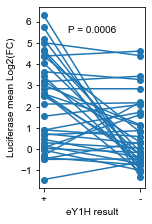

In [10]:
# averaging over each gene/bait with both positive and negative isoforms
avrg_paired = (df.groupby(['TF_Name', 'Bait', 'Interaction?'])
    ['Log2(FC)']
    .mean()
    .reset_index()
    .pivot(columns='Interaction?',
           index=['TF_Name', 'Bait'],
           values='Log2(FC)'))
avrg_paired = avrg_paired.dropna()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=2, h=3)
for _i, row in avrg_paired.iterrows():
    ax.plot(['+', '-'],
            [row['yes'], row['no']],
            'o-',
            color='C0')
ax.set_xlabel('eY1H result')
ax.set_ylabel('Luciferase mean Log2(FC)')
effectsize, pvalue = stats.ttest_rel(avrg_paired['yes'].values,
                avrg_paired['no'].values)
ax.text(x=0.5, y=5.5, s='P = {:.1}'.format(pvalue), ha='center')
fig.savefig('../figures/PDI-luciferase_validation_pair-plot.pdf',
            bbox_inches='tight')

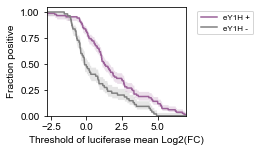

In [11]:
# titration plot of positive vs negative
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.5, h=2.)
validation_titration_plot(data=df,
                          selections=[df['Y1H_positive'], 
                                      ~df['Y1H_positive']],
                          score_column='Log2(FC)',
                          labels=['eY1H +', 'eY1H -'],
                          colors=[COLOR_PURPLE, 'grey'],
                          ax=ax)
ax.set_xlabel('Threshold of luciferase mean Log2(FC)')
fig.savefig('../figures/PDI-luciferase_validation_titration-plot.pdf',
            bbox_inches='tight')

In [12]:
def p_value(row):
    a = row[['Replicate1', 'Replicate2', 'Replicate3']].values
    b = row['Average (empty-pEZY3-VP160)']
    # added the list call because I was getting a weird error
    return stats.ttest_1samp(list(a), b, alternative='greater').pvalue

df['p-value'] = df.apply(p_value, axis=1)

In [13]:
df['positive'] = (df['p-value'] < 0.05) & (df['Log2(FC)'] >= 1)

In [14]:
df.groupby('Interaction?')['positive'].mean()

Interaction?
no     0.309091
yes    0.593023
Name: positive, dtype: float64

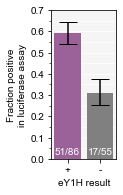

In [15]:
from ccsblib.ccsbplotlib import validation_plot
from plotting import COLOR_PURPLE

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.6, h=2.6)
validation_plot(data=df,
                          selections=[df['Y1H_positive'], 
                                      ~df['Y1H_positive']],
                          result_column='positive',
                          labels=['+', '-'],
                          colors=[COLOR_PURPLE, 'grey'],
                          errorbar_capsize=0.25,
                          ax=ax)
ax.set_ylim(0, 0.7)
ax.set_xlabel('eY1H result')
ax.set_ylabel('Fraction positive\nin luciferase assay')
fig.savefig('../figures/PDI-luciferase_validation_bar-plot.pdf',
            bbox_inches='tight')

In [16]:
stats.fisher_exact([[51, 86-51], [17, 55-17]])

SignificanceResult(statistic=3.257142857142857, pvalue=0.0010981868706350598)